# imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
import glob
import pandas as pd
from itertools import cycle
import colors
import matplotlib.pyplot as plt
%matplotlib inline


# Functions

In [2]:
def data_and_pred_channel(data,channel_vec):
    return np.array([data[i,[0,c+1],:,:] for i,c in enumerate(channel_vec)])


def show_image(img):
    plt.imshow(img, cmap='Greys')

    
def choose_one_channel(data,channel_vec,keep_dim=True):
    x = np.array([data[i,c+1,:,:] for i,c in enumerate(channel_vec)])
    if keep_dim:
        return np.expand_dims(np.array(x), axis=1)
    return x


def normalize_single_cannel(data):
    div = np.sum(data,axis=2)
    div = np.sum(div,axis=2)
    return np.transpose(np.transpose(data,(2,1,0,3))/div,(2,1,0,3))


def flat_all_samples(np_data):
    return np_data.reshape([np_data.shape[0],-1])

def calc_out_layer_size(width, filter_size, stride=1, padding=0):
    return int((width-filter_size+2*padding)/stride + 1)


def plot_history(history):

    fig = plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title('Acc Vs. epoch')
    plt.legend(['acc','val_acc'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss Vs. epoch')
    plt.legend(['loss','val_loss'])
    
from sklearn.metrics import roc_curve, auc
def plot_roc(y_test, pred):
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, xclasses, yclasses, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=xclasses, yticklabels=yclasses, 
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    if normalize:
        thresh = 0.75
    else:
        thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def plot_multy_roc(pred_vec,y_test,methodes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test, pred_vec[i])
        roc_auc[i] = auc(fpr[i], tpr[i])




    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} (area = {1:0.2f})'.format(methodes[i],roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")


# Load Dada

In [3]:
with open('../data/natural_adv_shap_softmax/mnist_natural_examples_classified_correctly.pkl', 'rb') as f:
    natural = pickle.load(f)

with open('../data/natural_adv_shap_softmax/mnist_natural_examples_misclassified.pkl', 'rb') as f:
    misclassified = pickle.load(f)

with open('../data/natural_adv_shap_softmax/mnist_adv_examples_misclassified_pertu_6.pkl', 'rb') as f:
    adversarial = pickle.load(f)
    
    
natural['X'].shape, misclassified['X'].shape, misclassified['X'].shape[0]/natural['X'].shape[0]

((9343, 11, 28, 28), (657, 11, 28, 28), 0.07032002568768062)

we have 3 bad explanations:
    1. image of 2 classified to 2             -> look on the explanations of 8 (8500 samples) - weak_exp
    2. adversarial image of 2 classified to 8 -> look on the explanations of 8 (inf samples)  - adv_exp
    3. image of 2 missclassified to 8         -> look on the explanations of 8 (54 samples)   - wrong_exp
    
There is only one good explanation:
    1. image of 8 classified to 8             -> look on the explanations of 8 (850 samples)  - good_exp

In [13]:
n=4 #the digit we learn to explain

noncnum = natural['X'][[natural['y']!=n]] #get non-n num data
adv_data = adversarial['X'][[adversarial['y']==n]][:15]
pred_as_n = misclassified['X'][[misclassified['net_pred']==n]]
n_bool_ind = [natural['y']==n]
cnum = natural['X'][n_bool_ind] #get the samples of n

y_softmax_prob = natural['softmax_prob'][n_bool_ind]
y_softmax_entropy = natural['softmax_entropy'][n_bool_ind].reshape(-1,1)
y = np.concatenate((y_softmax_prob,y_softmax_entropy),axis=1)

# weak_exp = choose_one_channel(noncnum, [n]*noncnum.shape[0]) #get non-n explenation
# adv_exp = choose_one_channel(adv_data, [n]*adv_data.shape[0]) #get non-n explenation
# wrong_exp = choose_one_channel(pred_as_n, [n]*pred_as_n.shape[0]) #get n explenation
# good_exp = choose_one_channel(cnum, [n]*cnum.shape[0]) #get good explenations to n

# weak_exp = normalize_single_cannel(weak_exp) 
# adv_exp = normalize_single_cannel(adv_exp)
# wrong_exp = normalize_single_cannel(wrong_exp)
# good_exp = normalize_single_cannel(good_exp)

weak_exp = data_and_pred_channel(noncnum, [n]*noncnum.shape[0]) #get non-n explenation
adv_exp = data_and_pred_channel(adv_data, [n]*adv_data.shape[0]) #get non-n explenation
wrong_exp = data_and_pred_channel(pred_as_n, [n]*pred_as_n.shape[0]) #get n explenation
good_exp = data_and_pred_channel(cnum, [n]*cnum.shape[0]) #get good explenations to n

good_exp_train, good_exp_test, good_exp_y_train, good_exp_y_test = train_test_split(good_exp, y, test_size=0.3)

X_train = np.concatenate((weak_exp,good_exp_train, adv_exp))
y_train = np.array([1]*weak_exp.shape[0]+[0]*good_exp_train.shape[0] + [1]*adv_exp.shape[0])
y_train_org = np.array([1]*weak_exp.shape[0]+[0]*good_exp_train.shape[0] + [2]*adv_exp.shape[0])



X_test = np.concatenate((wrong_exp,good_exp_test))
y_test =np.array([1]*wrong_exp.shape[0]+[0]*good_exp_test.shape[0])
y_test_org = np.array([3]*wrong_exp.shape[0]+[0]*good_exp_test.shape[0])


y_test_softmax_prob = np.concatenate((misclassified['softmax_prob'][[misclassified['net_pred']==n]].reshape(-1),
                                      good_exp_y_test[:,0].reshape(-1)))
y_test_softmax_entropy = np.concatenate((misclassified['softmax_entropy'][[misclassified['net_pred']==n]].reshape(-1),
                                         good_exp_y_test[:,1].reshape(-1)))

# Data exploration

In [25]:
def plot_explanations(nrows, single_channel_data, normalize=False):
    
    if normalize:
        single_channel_data = normalize_single_cannel(single_channel_data) 
    
    fig = plt.figure(figsize=(15,10))
    for i in range(nrows*5):
        plt.subplot(nrows,5,i+1)
        plt.imshow(single_channel_data[i][0],cmap=colors.red_transparent_blue)

## weak epx.

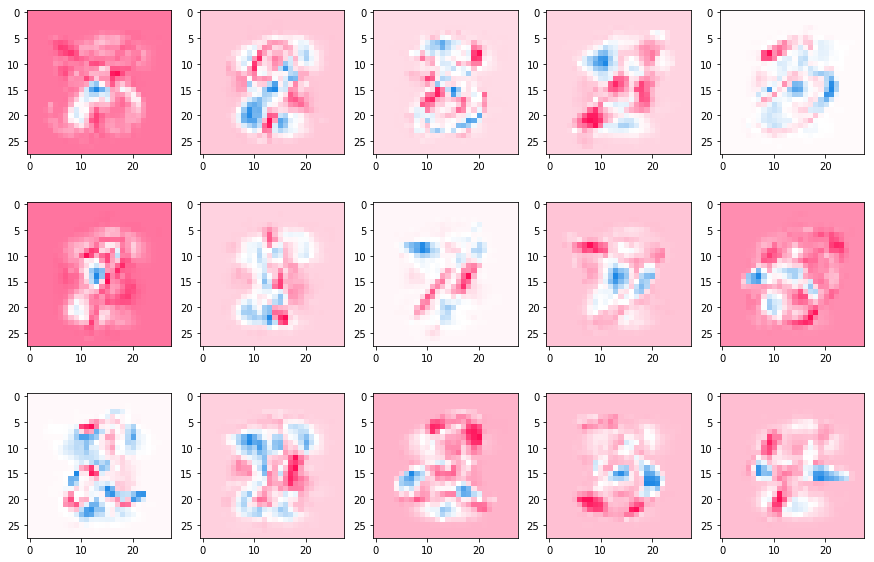

In [26]:
weak_exp = choose_one_channel(noncnum, [n]*noncnum.shape[0]) #get non-n explenation
plot_explanations(3, weak_exp)

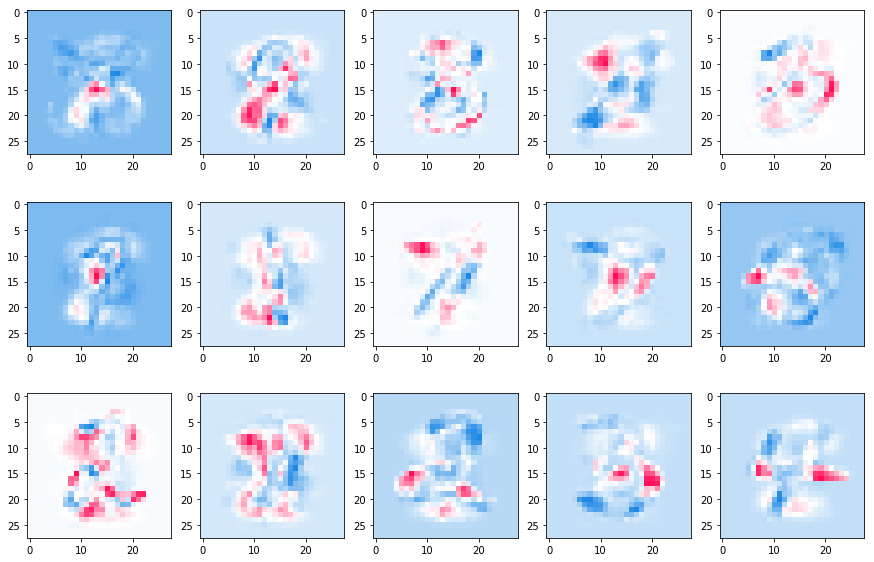

In [27]:
plot_explanations(3, weak_exp, True)

## adv. exp.

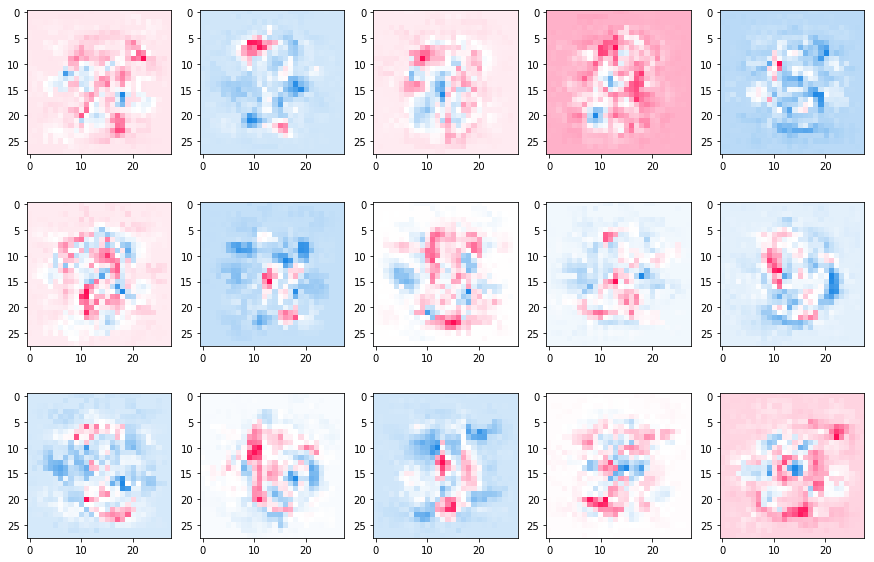

In [30]:
adv_exp = choose_one_channel(adv_data, [n]*adv_data.shape[0]) #get non-n explenation
plot_explanations(3, adv_exp)

In [ ]:
plot_explanations(3, adv_exp, True)

## wrong exp.

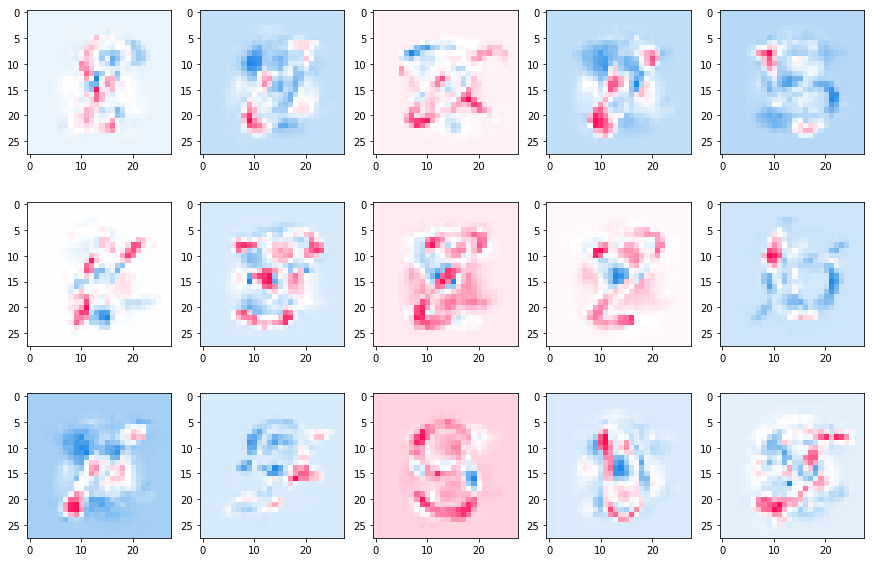

In [31]:
wrong_exp = choose_one_channel(pred_as_n, [n]*pred_as_n.shape[0])
plot_explanations(3, wrong_exp)

In [ ]:
plot_explanations(3, wrong_exp, True)

## Good exp.

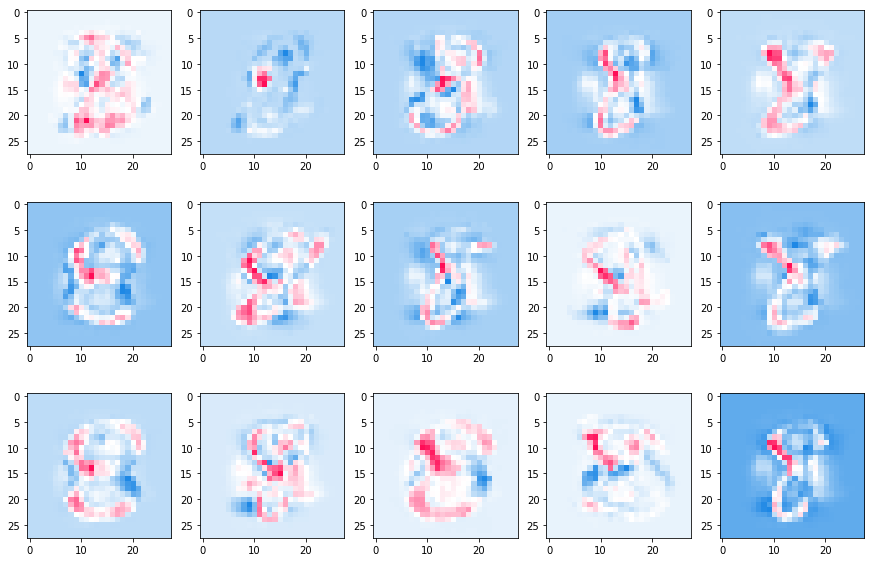

In [32]:
good_exp = choose_one_channel(cnum, [n]*cnum.shape[0]) #get good explenations to nfig = plt.figure(figsize=(15,5))
plot_explanations(3, good_exp)

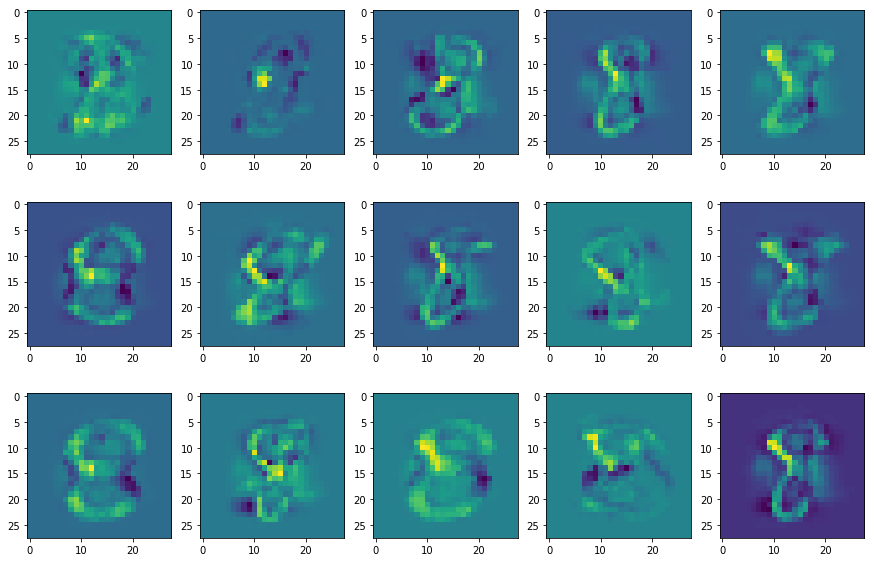

In [175]:
plot_explanations(3, good_exp, True)

# keras modle

In [14]:
from keras.models import Input, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [15]:
# change CWH -> WHC
X_train = np.transpose(X_train, (0, 2, 3, 1))
X_test = np.transpose(X_test, (0, 2, 3, 1))

In [16]:
inputs = Input(shape=X_train.shape[1:])
x = Conv2D(16,3,strides=(1, 1), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)

x = Conv2D(32,5,strides=(1, 1), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.5)(x)


x = Flatten()(x)
x = Dense(30, activation='relu')(x)
x = Dropout(rate=0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

In [17]:
model = Model(inputs=inputs, outputs=pred)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 32)          0         
__________

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, class_weight='auto')

Train on 9097 samples, validate on 299 samples
Epoch 1/50
9097/9097 [==============================] - 3s 302us/step - loss: 0.1674 - acc: 0.9394 - val_loss: 0.3152 - val_acc: 0.9130
Epoch 2/50
9097/9097 [==============================] - 2s 256us/step - loss: 0.0539 - acc: 0.9816 - val_loss: 0.1872 - val_acc: 0.9365
Epoch 3/50
9097/9097 [==============================] - 3s 337us/step - loss: 0.0315 - acc: 0.9898 - val_loss: 0.1564 - val_acc: 0.9532
Epoch 4/50
9097/9097 [==============================] - 9s 949us/step - loss: 0.0202 - acc: 0.9932 - val_loss: 0.1697 - val_acc: 0.9498
Epoch 5/50
9097/9097 [==============================] - 10s 1ms/step - loss: 0.0182 - acc: 0.9938 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 6/50
9097/9097 [==============================] - 9s 1ms/step - loss: 0.0170 - acc: 0.9946 - val_loss: 0.1314 - val_acc: 0.9498
Epoch 7/50
9097/9097 [==============================] - 9s 1ms/step - loss: 0.0197 - acc: 0.9943 - val_loss: 0.1149 - val_acc: 0.9532
Epoch 

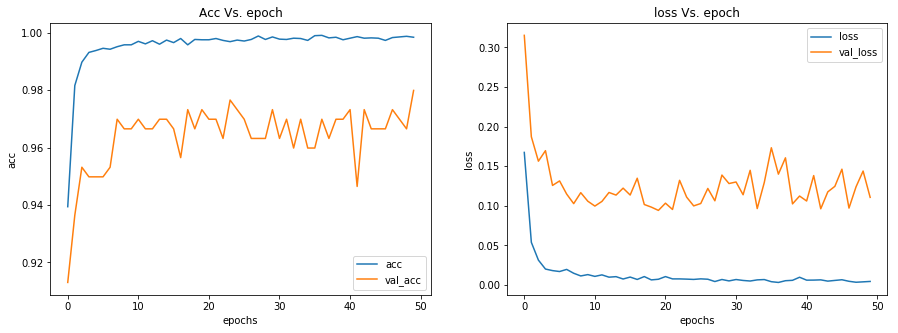

In [19]:
plot_history(history)

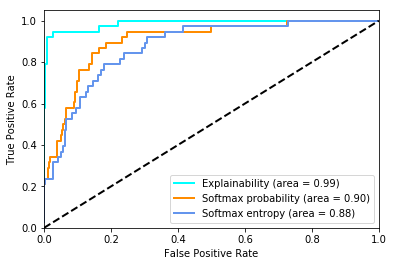

In [20]:
pred = model.predict(X_test)
pred_vec = [pred, 1-y_test_softmax_prob, y_test_softmax_entropy]
plot_multy_roc(pred_vec,y_test,methodes = ['Explainability', 'Softmax probability', 'Softmax entropy'])

On Test set
Confusion matrix, without normalization
Normalized confusion matrix


/home/lab/amosy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


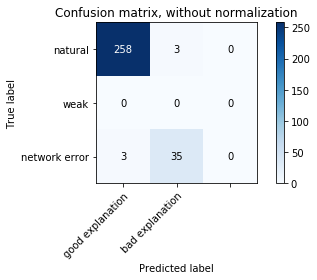

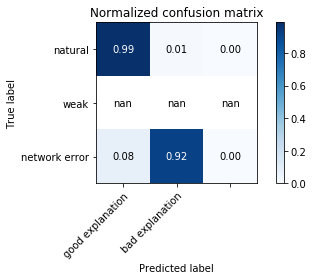

In [21]:
print('On Test set')
th=0.5
pred[pred >= th] = 1
pred[pred < th] = 0

xclasses = {'good explanation':0, 'bad explanation':1}
yclasses = {'natural':0, 'weak':1, 'network error':3}

plot_confusion_matrix(y_test_org, pred, xclasses, yclasses)
plot_confusion_matrix(y_test_org, pred, xclasses, yclasses, normalize=True)

In [288]:
xclasses = {'good explanation':0, 'bad explanation':1}
yclasses = {'natural':0, 'weak':1, 'adversarial':2, 'network error':3}

On train set
Confusion matrix, without normalization
Normalized confusion matrix


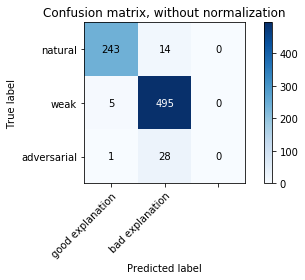

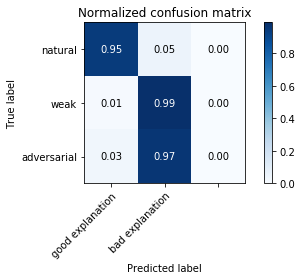

In [289]:
print('On train set')
train_pred = model.predict(X_train)
train_pred[train_pred >= 0.5] = 1
train_pred[train_pred < 0.5] = 0

plot_confusion_matrix(y_train_org, train_pred, xclasses, yclasses)
plot_confusion_matrix(y_train_org, train_pred, xclasses, yclasses, normalize=True)